In [ ]:
!gdown 1jIR6GiQqHWXhwqZr8K25tbkyLBhVWAIT # 전처리 완료 후 구글 드라이브에 업로드한 pickle 데이터다운로드

Downloading...
From: https://drive.google.com/uc?id=1jIR6GiQqHWXhwqZr8K25tbkyLBhVWAIT
To: /content/Downloads.zip
100% 16.4M/16.4M [00:01<00:00, 11.1MB/s]


In [ ]:
!unzip /content/Downloads.zip # unzip 데이터

Archive:  /content/Downloads.zip
  inflating: saved_model.pb          
  inflating: sents_en_in.pickle      
  inflating: sents_ko_in.pickle      
  inflating: sents_ko_out.pickle     


In [ ]:
pip install fast-mosestokenizer # 영어용 tokenizer 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 801 kB 12.1 MB/s 


In [ ]:
pip install soynlp # 한글용 tokenizer (L_tokenizer)를 위한 soynlp 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 416 kB 11.7 MB/s 


In [ ]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from soynlp.tokenizer import LTokenizer
from mosestokenizer import MosesTokenizer
import pickle
import keras
from keras.callbacks import EarlyStopping
from tqdm import tqdm
import urllib.request
from soynlp import DoublespaceLineCorpus
from soynlp.word import WordExtractor
from soynlp.tokenizer import MaxScoreTokenizer

## Download the data


미등록단어 문제 (Out Of Vocabulary)를 해결 하기 위해 '2016-10-20' 뉴스 기사로부터 학습을 진행\
WordExtractor를 통해 학습을 한 후 나온 단어 점수로 본문(구어체)의 분류를 진행

In [ ]:
!gdown --id 1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis
To: /content/1_구어체(1).xlsx
100% 15.8M/15.8M [00:00<00:00, 385MB/s]


In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/lovit/soynlp/master/tutorials/2016-10-20.txt", filename="2016-10-20.txt")

('2016-10-20.txt', <http.client.HTTPMessage at 0x7f3d6e71f710>)

In [ ]:
corpus = DoublespaceLineCorpus("2016-10-20.txt")
word_extractor = WordExtractor()
word_extractor.train(corpus)
word_score_table = word_extractor.extract()

30091

In [ ]:
import pandas as pd

df = pd.read_excel('/content/1_구어체(1).xlsx')
df

,SID,원문,번역문
0,1,'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 ...,Bible Coloring' is a coloring application that...
1,2,씨티은행에서 일하세요?,Do you work at a City bank?
2,3,푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.,"PURITO's bestseller, which recorded 4th rough ..."
3,4,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.,In Chapter 11 Jesus called Lazarus from the to...
4,5,"6.5, 7, 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다.",I would feel grateful to know how many stocks ...
...,...,...,...
199995,199996,나는 먼저 청소기로 바닥을 밀었어요.,"First of all, I vacuumed the floor."
199996,199997,나는 먼저 팀 과제를 하고 놀러 갔어요.,I did the team assignment first and went out t...
199997,199998,나는 비 같은 멋진 연예인을 좋아해요.,I like cool entertainer like Rain.
199998,199999,나는 멋진 자연 경치를 보고 눈물을 흘렸어.,I cried seeing the amazing scenery.


In [ ]:
with open ('/content/total.txt', 'w') as f:
    for i,j in zip(df['번역문'],df['원문']):
        f.write(f"{i}\t{j}\n")
f.close()

## Modeling


In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
hidden_units = 256  # Latent dimensionality of the encoding space. ## 각각의 lstm 벡터 크기
embedding_dim = 64
num_samples = 200000  # Number of samples to train on.

In [ ]:
def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []
    # so_of_s = ['<sos>', '<eos>']

  with open("total.txt", "r") as lines:   ## 텍스트 파일을 한줄 씩 불러온다. 
    for i, line in tqdm(enumerate(lines)):   
      # source 데이터와 target 데이터 분리
      en_line, kr_line = line.strip().split('\t')   ## 탭으로 구분되어있으므로 탭을 기준으로 split 

      # 영문 데이터 전처리 
      tokenizer_en = MosesTokenizer('en')
      en_line = tokenizer_en.tokenize(en_line)
      reversed_en_line = list(reversed(en_line))
      


      scores = {word:score.cohesion_forward for word, score in word_score_table.items()}
      l_tokenizer = LTokenizer(scores = scores)
      kr_line = l_tokenizer.tokenize(kr_line)


      kr_line_in =  ['<sos>'] + kr_line
      kr_line_out = kr_line + ['<eos>']

      encoder_input.append(reversed_en_line)
      decoder_input.append(kr_line_in)
      decoder_target.append(kr_line_out)

      if i == num_samples - 1:
        break
                
  return encoder_input, decoder_input, decoder_target

In [ ]:
sents_en_in, sents_ko_in, sents_ko_out  = load_preprocessed_data()

199999it [1:50:55, 30.05it/s]


In [ ]:
with open('sents_en_in.pickle', 'rb') as f:
  sents_en_in = pickle.load(f)

with open('/content/sents_ko_in (1).pickle', 'rb') as f:
  sents_ko_in = pickle.load(f)

with open('sents_ko_out.pickle', 'rb') as f:
  sents_ko_out = pickle.load(f)

In [ ]:
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_ko_in[:5])
print('디코더의 레이블 :',sents_ko_out[:5])

인코더의 입력 : [['.', 'Bible', 'the', 'in', 'stories', 'beautiful', 'experience', 'to', 'you', 'allows', 'that', 'application', 'coloring', 'a', 'is', "'", 'Coloring', 'Bible'], ['?', 'bank', 'City', 'a', 'at', 'work', 'you', 'Do'], ['.', 'abroad', 'from', 'mouth', 'of', 'words', 'by', '-cuts', 'rough', '4th', 'recorded', 'which', ',', 'bestseller', "'s", 'PURITO'], ['.', 'dead', 'the', 'from', 'him', 'raised', 'and', 'tomb', 'the', 'from', 'Lazarus', 'called', 'Jesus', '11', 'Chapter', 'In'], ['.', '8', 'and', ',', '7', ',', '6.5', 'size', 'of', 'secured', 'be', 'will', 'stocks', 'many', 'how', 'know', 'to', 'grateful', 'feel', 'would', 'I']]
디코더의 입력 : [['<sos>', "'Bible", "Coloring'은", '성경의', '아름다운', '이야기를', '체험', '할', '수', '있는', '컬러', '링', '앱입니다.'], ['<sos>', '씨티은행', '에서', '일하세요?'], ['<sos>', '푸리토의', '베스트셀러', '는', '해외에서', '입소문', '만으로', '4차', '완판을', '기록하', '였다.'], ['<sos>', '11', '장에서는', '예수님이', '이번', '엔', '나사로를', '무덤에서', '불러내어', '죽은', '자', '가운데', '서', '살리셨습니다.'], ['<sos>', '6.5,', '7,', 

In [ ]:
#영어
tokenizer_en = Tokenizer(filters="", lower = False)

tokenizer_en.fit_on_texts(sents_en_in)

encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)

In [ ]:
# 한국어
tokenizer_ko= Tokenizer(filters ="", lower = False)
tokenizer_ko.fit_on_texts(sents_ko_in)     ## SOS 가 dict 에 들어감 
tokenizer_ko.fit_on_texts(sents_ko_out)    ## EOS 가 dict 에 들어감 

decoder_input = tokenizer_ko.texts_to_sequences(sents_ko_in)
decoder_target = tokenizer_ko.texts_to_sequences(sents_ko_out)

# padding

In [ ]:
encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_target = pad_sequences(decoder_target, padding='post')

In [ ]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)
## 인코더와 디코더는 길이다 달라도 되지만, 디코더의 입력과 레이블은 같아야 한다. 

인코더의 입력의 크기(shape) : (200000, 53)
디코더의 입력의 크기(shape) : (200000, 39)
디코더의 레이블의 크기(shape) : (200000, 39)


In [ ]:
print(tokenizer_en.word_index)
print(tokenizer_ko.word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_ko.word_index) + 1

print(f"영어 단어 집합의 크기 : {src_vocab_size}, 한국어 단어 집합의 크기 : {tar_vocab_size}")

영어 단어 집합의 크기 : 48870, 한국어 단어 집합의 크기 : 150082


In [ ]:
src_to_index = tokenizer_en.word_index  # word : idx
index_to_src = tokenizer_en.index_word  # idx : word
tar_to_index = tokenizer_ko.word_index # word : idx
index_to_tar = tokenizer_ko.index_word # idx : word

In [ ]:
## 데이터 셋이 3개이기 때문에 직접 분리 
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [117727 100741 152685 ...  42384  13798 148939]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
n_of_val = int(num_samples*0.1)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (180000, 53)
훈련 target 데이터의 크기 : (180000, 39)
훈련 target 레이블의 크기 : (180000, 39)
테스트 source 데이터의 크기 : (20000, 53)
테스트 target 데이터의 크기 : (20000, 39)
테스트 target 레이블의 크기 : (20000, 39)


# Modeling

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Input
from keras.layers import AdditiveAttention 


In [ ]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층

###############
encoder_lstm = LSTM(hidden_units, return_sequences = True, return_state = True) # 상태값 리턴을 위해 return_state는 True
###############

encoder_outputs, state_h, state_c = encoder_lstm(enc_emb) # 은닉 상태와 셀 상태를 리턴

encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
      super().__init__()

      self.W1 = tf.keras.layers.Dense(units, use_bias = False) # W1@ht 
      self.W2 = tf.keras.layers.Dense(units, use_bias = False) # W2@hs 

      self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value):

      # W1 @ ht 
      w1_query = self.W1(query)

      # W2 @ hs 
      w2_key = self.W2(value)

      # attention
      context_vector, attention_weights = self.attention(inputs = [w1_query, value, w2_key], return_attention_scores = True)

      return context_vector, attention_weights


In [ ]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 임베딩 층
dec_emb_layer = Embedding(tar_vocab_size, hidden_units)

# 임베딩 결과
dec_emb = dec_emb_layer(decoder_inputs) 

######################
# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 
######################

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _ , _ = decoder_lstm(dec_emb,initial_state=encoder_states)

######################
# attention
S_ = tf.concat([state_h[:, tf.newaxis, :], decoder_outputs[:, :-1, :]], axis=1)

attention = BahdanauAttention(hidden_units)
context_vector, _ = attention(S_, encoder_outputs)

concat = tf.concat([decoder_outputs, context_vector], axis=-1)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(concat)

######################

In [ ]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.01)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, 
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=96, epochs=6, callbacks=[callback,early_stop])

Epoch 1/6
1875/1875 [==============================] - 1395s 744ms/step - loss: 1.5851 - acc: 0.7999 - val_loss: 1.5479 - val_acc: 0.8055 - lr: 0.0010
Epoch 2/6
1875/1875 [==============================] - 1394s 744ms/step - loss: 1.3471 - acc: 0.8133 - val_loss: 1.4303 - val_acc: 0.8136 - lr: 0.0010
Epoch 3/6
1875/1875 [==============================] - 1394s 743ms/step - loss: 1.1281 - acc: 0.8244 - val_loss: 1.3650 - val_acc: 0.8187 - lr: 0.0010
Epoch 4/6
1875/1875 [==============================] - 1394s 743ms/step - loss: 0.9113 - acc: 0.8371 - val_loss: 1.3520 - val_acc: 0.8215 - lr: 0.0010
Epoch 5/6
1875/1875 [==============================] - 1394s 743ms/step - loss: 0.7200 - acc: 0.8603 - val_loss: 1.3662 - val_acc: 0.8223 - lr: 0.0010
Epoch 6/6
1875/1875 [==============================] - 1394s 743ms/step - loss: 0.5909 - acc: 0.8788 - val_loss: 1.3835 - val_acc: 0.8227 - lr: 0.0010


In [ ]:
tf.saved_model.save(model, "/content")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/assets


# Transform using Training Model

In [ ]:
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])

In [ ]:
# 디코더 

# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

######################
encoder_state_h = Input(shape=(hidden_units,))
encoder_outputs2 = Input(shape =(None, hidden_units,))
######################

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h, state_c = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h, state_c]

######################
S_ = tf.concat([encoder_state_h[:, tf.newaxis, :], decoder_outputs2[:, :-1, :]], axis=1)

# Attention
context_vector, att_score = attention(S_, encoder_outputs2)
decoder_concat = tf.concat([decoder_outputs2, context_vector], axis=-1)

# 모든 시점에 대해서 단어 예측 (Fully Connected)
decoder_outputs2 = decoder_dense(decoder_concat)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs, encoder_state_h, encoder_outputs2] + decoder_states_inputs,
    [decoder_outputs2, att_score] + decoder_states2)

######################

# 결과 확인 함수

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [ ]:
def decode_sequences(sentence):
  # 문장 전처리를 위해 추가한 부분
  ##################
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  max_src_len, max_tar_len  = 57, 30

  attention_plot = np.zeros((max_tar_len, max_src_len))

  inputs = [tokenizer_en.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_src_len,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  #################

  encoder_test, states_value = encoder_model.predict(inputs)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  for t in range(max_tar_len):
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, att_score, h, c = decoder_model.predict([target_seq, states_value[0], encoder_test] + states_value)

    # 어텐션 가중치 시각화를 위해 저장 
    att_score = tf.reshape(att_score, (-1, ))
    attention_plot[t] = att_score.numpy() 

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char


    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if sampled_char == '<eos>':
        break 

  return sentence, decoded_sentence, attention_plot

In [ ]:
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    # you need to change the fname based on your system, and the Chinese can be displayed in the plot
    # font = FontProperties(fname=r"./data/TaipeiSansTCBeta-Regular.ttf", size=14)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    # set the x-tick/y-tick labels with list of string labels
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation = 90)
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    # set tick locators
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [ ]:
def translate(sentence):
  sentence, result, attention_plot = decode_sequences(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
def translate_train(seq_index):
  input_seq = encoder_input_train[seq_index: seq_index + 1]

  sentence = seq_to_src(encoder_input_train[seq_index]).strip()
  _, result, attention_plot = decode_sequences(sentence)

  print('Input: %s' % (sentence))
  print("Right translation :",seq_to_tar(decoder_input_train[seq_index]))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: . time long a for you seen 't haven I because you with comfortable feel 't don I
Right translation : 나는 널 만난 지 얼마 되지 않아서 네가 편하지 않아 . 
Predicted translation:  오랫동안 같이 있지 않아서 당신과 함께 하는 것도 나쁘지 않아 . <eos>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47019 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50504 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44057 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_

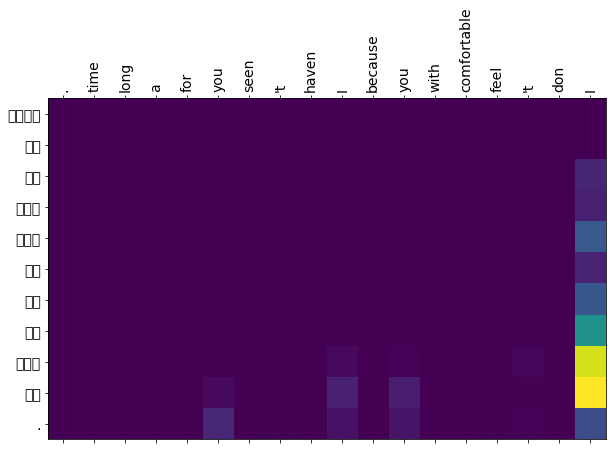

--------------------------------------------------
Input: . myself by go can I that know I
Right translation : 나는 내가 혼자 갈 수 있다 는 걸 알아 . 
Predicted translation:  내가 직접 할 수 있는 곳이 있다 고 생각 해요. <eos>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54624 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_

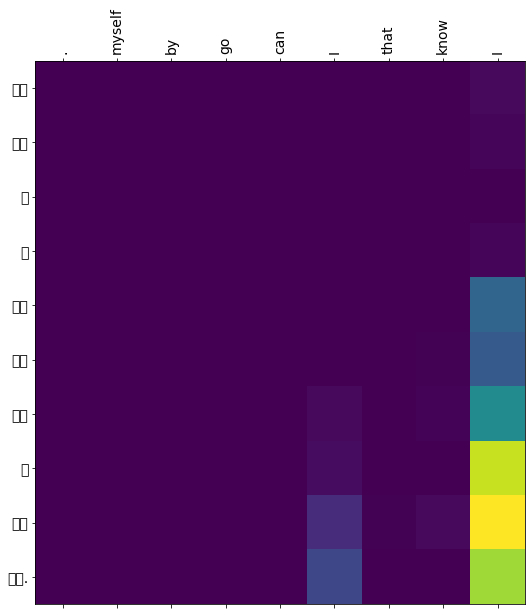

--------------------------------------------------
Input: . now sleepy 'm I as bed to go should I think I
Right translation : 난 졸려서 이만 자러 가봐야 할 것 같아. 
Predicted translation:  나는 지금 졸려서 이만 자러 가야 해. <eos>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47564 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47084 missing from current font.
  font.set_

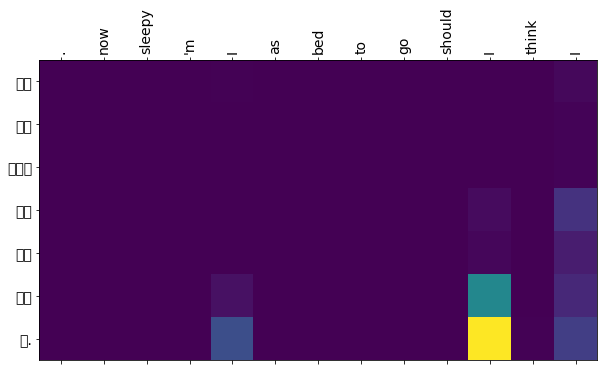

--------------------------------------------------
Input: . strength debtor the against violence the Spurred
Right translation : 강도는 채무자 에게 폭력을 가했습니다. 
Predicted translation:  강도는 채무자 에게 폭력을 가했습니다. <eos>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52292 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_

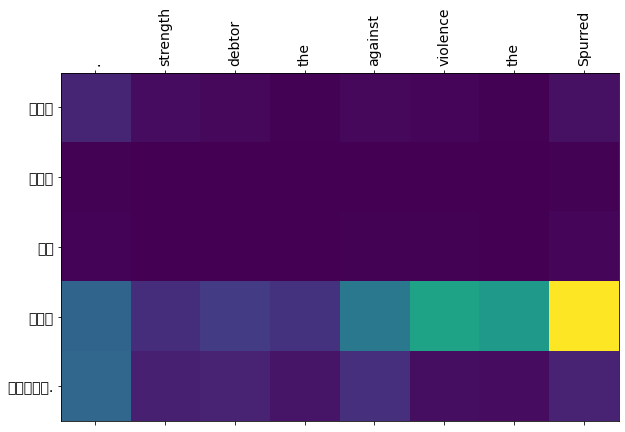

--------------------------------------------------
Input: . up give not do and pain the remember just So
Right translation : 그러 니 그 고통을 기억하고 포기하지 마라. 
Predicted translation:  그래서 그 자리에 도 포기하지 않고 가만히 서 포기하지 않고 가만히 있었어. <eos>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_

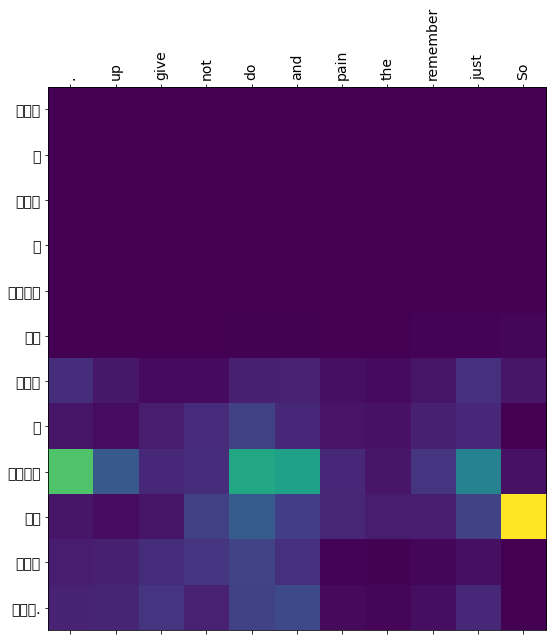

--------------------------------------------------


In [ ]:
for seq_index in [3, 50, 100, 300, 1001]:
  translate_train(seq_index)
  print("-"*50)

In [ ]:
!gdown 15ZRi4gYCXUOrp3ZUlVprcLrM8R9A3Rdh

Downloading...
From: https://drive.google.com/uc?id=15ZRi4gYCXUOrp3ZUlVprcLrM8R9A3Rdh
To: /content/영한테스트_영어.csv
100% 35.0k/35.0k [00:00<00:00, 40.9MB/s]


In [ ]:
df_test = pd.read_csv('/content/영한테스트_영어.csv', index_col = False)
df_test

,영어
0,This is good food for many people to eat toget...
1,I didn't check the list yet but more people th...
2,"Sure, I'll get Kimchi and pickles soon."
3,I think we should choose the second one.
4,"Sure, I have a lot of small bills."
...,...
495,"When you are watching a performance, it's impo..."
496,The toner pad with skin on it was really conve...
497,"Yes, I will check the state of the car before ..."
498,"It's too bad you can't join, but you're mother..."


In [ ]:
test_input = []

tokenizer_ed = MosesTokenizer('en')

for idx, row in df_test.iterrows():
  test_line = tokenizer_ed.tokenize(row[0])[::-1]
  test_input.append(test_line)

In [ ]:
test_input = tokenizer_en.texts_to_sequences(test_input)

In [ ]:
test_input = pad_sequences(test_input,padding='post')

In [ ]:
# 샘플 데이터 테스트를 위한 함수

def decode_sequenced(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  encoder_test, states_value = encoder_model.predict(input_seq)


  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, att_score, h, c = decoder_model.predict([target_seq, states_value[0], encoder_test] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [ ]:
answer = []

for seq_index in range(500):
  input_seq = test_input[seq_index: seq_index + 1]
  decoded_sentence = decode_sequenced(input_seq)
  
  answer.append(decoded_sentence)


In [ ]:
test = pd.DataFrame(answer)

result = pd.concat([df_test, test], axis = 1)

In [ ]:
result

,영어,0
0,This is good food for many people to eat toget...,이 음식 은 건강 과 어울리는 음식 입니다. <eos>
1,I didn't check the list yet but more people th...,"아직 발송되지 않은 건 아직 받지 못했 지만, 아직 오지 않은 상황이 라 생각 했..."
2,"Sure, I'll get Kimchi and pickles soon.","김치를 먹고 , 곧 김치를 넣고 볶습니다. <eos>"
3,I think we should choose the second one.,우리 는 이 두 명을 믿습니다 . <eos>
4,"Sure, I have a lot of small bills.","물론 이죠, 저는 굉장 히 불편해 요. <eos>"
...,...,...
495,"When you are watching a performance, it's impo...",당신의 핸드 폰을 이해하는 데 방해가 되지 않아 . <eos>
496,The toner pad with skin on it was really conve...,그 피부 에 소금을 섞으면 정말 맛있 어요. <eos>
497,"Yes, I will check the state of the car before ...","네, 해당 건은 해당 건은 해당 건은 해당 건은 해당 건은 해당 건은 진행 될 수..."
498,"It's too bad you can't join, but you're mother...",오랜만에 만난 지 얼마 되지 않아 오랜만에 만나 서 오랜만에 놀러 올게! <eos>


In [ ]:
result.to_csv('test.csv',index=False)